# SVM and LR

This will start with using SKLearn, but might change to Tensorflow

For now, only one stock will be used, so for now my file that takes in data will find that one stock, and it will be one from the sp500

In [1]:
import pandas as pd
import os
import glob
from pathlib import Path

curr_data_folder = Path('stock_market_data/sp500/csv/')

symbol_csvs_paths = list(curr_data_folder.glob('*.csv'))

In [2]:

import numpy as np

def stock_csv_parser(fileName, y_day_ct=5):

    symbol_df = pd.read_csv(fileName)

    # I want to get the percentage change, so if I wanted to make a threshold such as 2%
    # I will first drop any open if it is zero just in case to prevent division by zero
    symbol_df = symbol_df[symbol_df['Open'] != 0]
    y = symbol_df['Close'] / symbol_df['Open']
    y_value = symbol_df['Close'] / symbol_df['Open']


    y = [1 if each > 1.005 else 0 for each in y]

    # print(y)
    # print("data points:", str(len(y)), "\t Results as success:", np.count_nonzero(y))
    
    return symbol_df, y, y_value



Now that we have one of the stock in, we will try to moddify the data, then train it with svm for now
I will come back later to get it to do more than just one stock, this is for quicker testing for now

In [3]:
from sklearn.preprocessing import StandardScaler

def scaler_function(symbol_df):
    try:
        symbol_df = symbol_df.drop(['Date'], axis = 1)
        symbol_df = symbol_df.dropna()
    except:
        print("Column missing")
    

    # print(symbol_df.iloc[0])

    # print(symbol_df)

    scaler = StandardScaler()
    X = scaler.fit_transform(symbol_df)

    return X


I am unsure if I should do PCA first or append 10 days to each other then do it
I suspect I will do PCA after since each day will be highly correlated to the previous day

In [4]:

def X_day_appender(day_info, day_ct=10, y_day_ct=5):
    result = []
    for i in range(len(day_info) - (day_ct + y_day_ct)):
        result.append(day_info[i:i+day_ct, :].flatten())
    return result

I want to now use PCA because this data will all naturally be correlated

In [5]:
from sklearn.decomposition import PCA

def principal_component_analyzer(X, n=3):
    pca = PCA(n_components=n)
    X_PCA = pca.fit_transform(X)
    return X_PCA

# print(X_PCA[0], len(X_PCA), len(y))


Now that I have done PCA, I want to split my data so that future data is not trained on

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

def data_spliter(X_PCA, y, day_ct, y_value):
    # This will split up my data, while keeping it in order
    y = y[5:]
    y_value = y_value[5:]
    X_train, X_test, y_train, y_test, y_value_train, y_value_test = train_test_split(X_PCA, y, y_value, test_size=0.2, shuffle=False)

    # I am removing some that are close or are in the train set at least part of the way
    X_test = X_test[5:]
    y_test = y_test[5:]
    y_value_test = y_value_test[5:]

    # I am then shuffleing the data, thought that might have only been NN that needed this step, I am unsure
    X_train, y_train, y_value_train = shuffle(X_train, y_train, y_value_train, random_state=42)
    X_test, y_test, y_value_test = shuffle(X_test, y_test, y_value_test, random_state=42)
    return X_train, X_test, y_train, y_test, y_value_train, y_value_test



Now that I have done quite a bit to the data, I will train it using SVM
I want to see if the results can have a high percision
I think percision is what I want the most because I do not want to have bad days be prediceted as good days

I will first be trying svc, because I want a classification
I might move to one class svm because there is a great deal of the results not meeting the threshold

I am using svc and not linear svc, because the documentation suggested linear svc if you have more than 10s of thousands of samples
Which when only doing one stock with this data set, there is not too many samples

In [7]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


def SVM_fitting(X_train, y_train, X_test):
    clf = SVC(gamma='auto')
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    return y_pred

def LR_fitting(X_train, y_train, X_test):
    clf = LogisticRegression()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    return y_pred



Now that it is train, I want to see what I can get out of the results

In [8]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

def score_returner(y_test, y_pred):
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # print("Accuracy: ", str(accuracy),  "\tPrecision: ", str(precision), "\tRecall: ", str(recall), "\tNumber of predicted days: ", str(np.count_nonzero(y_pred))) 
    return accuracy, recall, precision

So far the results are not great, I will continute to work to see if I can get any sort of result from this
I have tried a few stocks and General Electric is returning the best results so far

I plan to also add in a way to see the change in value if when predicted to be a good day, the stock is bought at open and sold at close
I plan to also try to test all sp500 stocks at once to see which ones give the best results

In [9]:
def symbol_train_test(file_path, mode_type=0,day_ct=10, y_day_ct=5):
    symbol_df, y, y_value = stock_csv_parser(file_path, y_day_ct)
    X = scaler_function(symbol_df)
    # X = principal_component_analyzer(X)
    X = X_day_appender(X, day_ct=day_ct)
    y = y[day_ct:]
    y_value = y_value[day_ct:]

    X = principal_component_analyzer(X,15)
    X_train, X_test, y_train, y_test, y_value_train, y_value_test = data_spliter(X, y, day_ct, y_value)
    y_pred = SVM_fitting(X_train, y_train, X_test)
    y_pred_lr = LR_fitting(X_train, y_train, X_test)
    accuracy, recall, precision = score_returner(y_test, y_pred)
    accuracy_lr, recall_lr, precision_lr = score_returner(y_test, y_pred_lr)

    trade_amount = 1
    pred_ct = 0
    for i in range(len(y_test)):
        if y_pred[i] == 1:
            pred_ct += 1
            trade_amount *= y_value_test.iloc[i]

    trade_amount_lr = 1
    pred_ct_lr = 0
    for i in range(len(y_test)):            
        if y_pred_lr[i] == 1:
            pred_ct_lr += 1
            trade_amount_lr *= y_value_test.iloc[i]
    
    trade_amount_combo = 1
    for i in range(len(y_test)):            
        if y_pred_lr[i] == 1 and y_pred[i] == 1:
            trade_amount_combo *= y_value_test.iloc[i]
        
    return accuracy, recall, precision, trade_amount, pred_ct, accuracy_lr, recall_lr, precision_lr, trade_amount_lr, pred_ct_lr, trade_amount_combo


In [10]:

file = open("SVM_Scores.csv", "a")
curr_string_to_write = "symbol,accuracy,recall,precision,trade_amount,pred_ct\n"
file.write(curr_string_to_write)
file.close()
file = open("LR_Scores.csv", "a")
curr_string_to_write = "symbol,accuracy,recall,precision,trade_amount,pred_ct\n"
file.write(curr_string_to_write)
file.close()


stock_name = []
stock_value = []
stock_value_lr = []
stock_value_combo = []

for each in symbol_csvs_paths:
    symbol = os.path.splitext(os.path.basename(each))
    try:
        accuracy, recall, precision, trade_amount, pred_ct, accuracy_lr, recall_lr, precision_lr, trade_amount_lr, pred_ct_lr, trade_amount_combo = symbol_train_test(each)
        stock_name.append(symbol[0])
        stock_value.append(trade_amount)
        stock_value_lr.append(trade_amount_lr)
        stock_value_combo.append(trade_amount_combo)
    except:
        accuracy, recall, precision, trade_amount, pred_ct = -999.999, -999.999, -999.999, 0, -999.999
        accuracy_lr, recall_lr, precision_lr, trade_amount_lr, pred_ct_lr = -999.999, -999.999, -999.999, 0, -999.999
        trade_amount_combo = 0
    curr_string_to_write = f"{symbol[0]},{accuracy},{recall},{precision},{trade_amount},{pred_ct}\n"
    file = open("SVM_Scores.csv", "a")
    file.write(curr_string_to_write)
    file.close()
    curr_string_to_write_lr = f"{symbol[0]},{accuracy_lr},{recall_lr},{precision_lr},{trade_amount_lr},{pred_ct_lr}\n"
    file = open("LR_Scores.csv", "a")
    file.write(curr_string_to_write_lr)
    file.close()


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12

In [11]:
# print(stock_name[:][:], stock_value, stock_value_lr)
# print("Total gain/loss on svm:",str(total_trade_amount),"Total gain/loss on lr:", str(total_trade_amount_lr))
# print(sum(stock_value), sum(stock_value_lr))

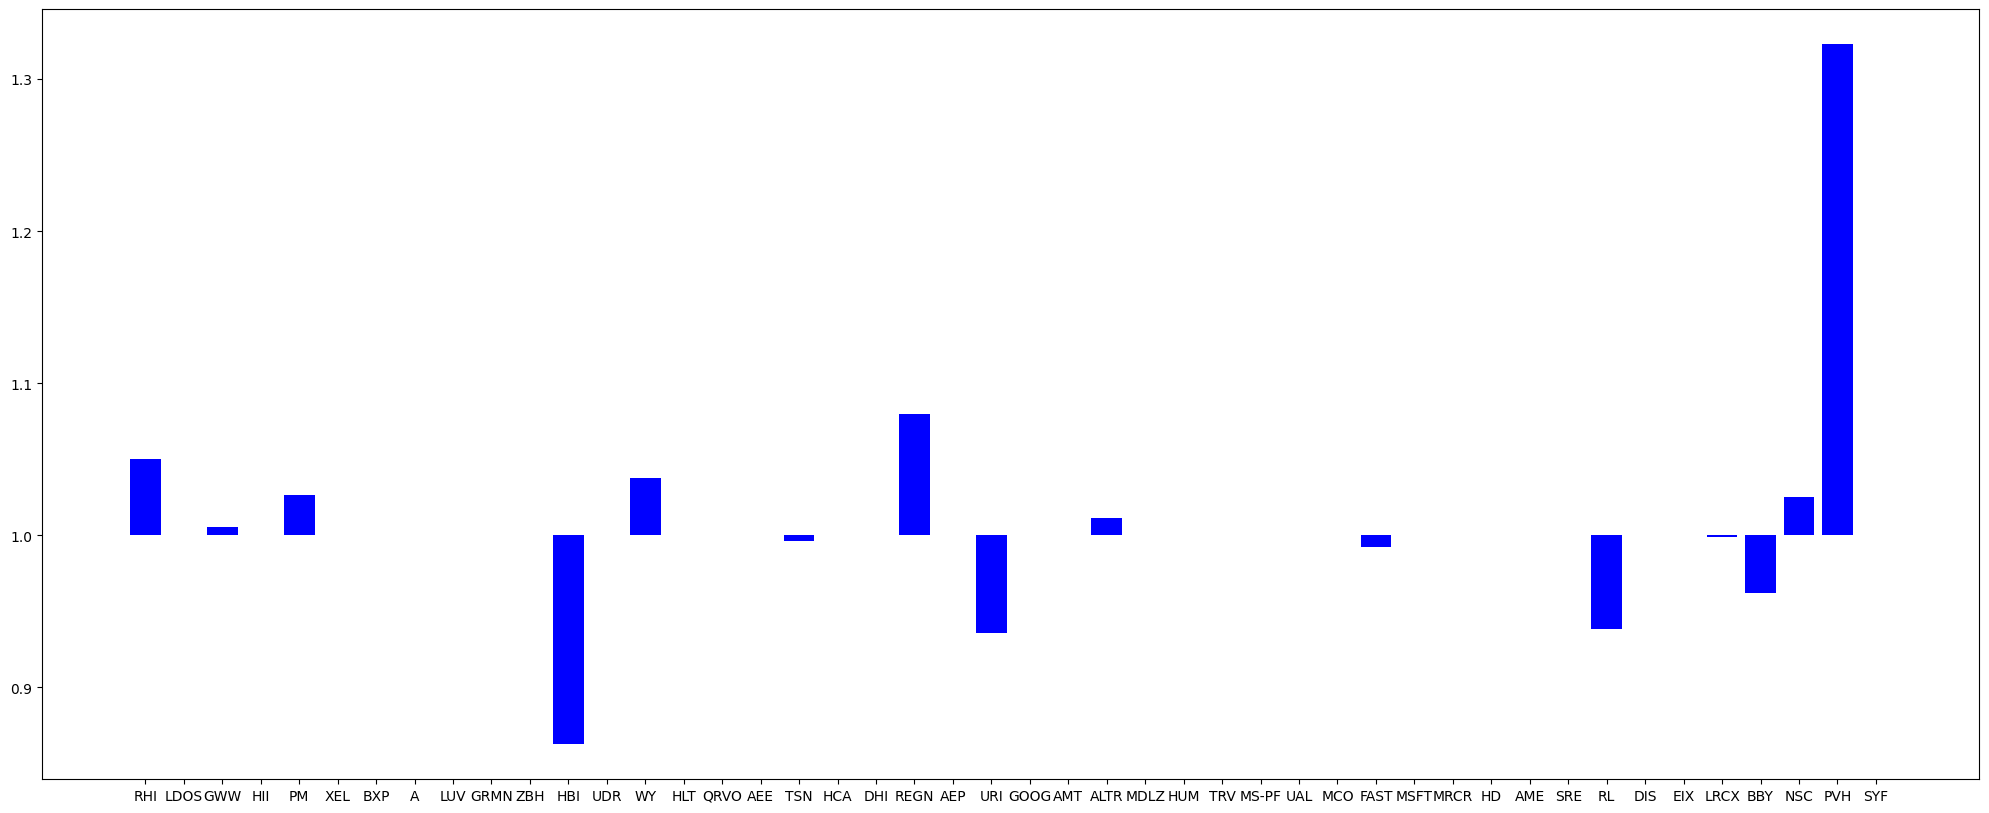

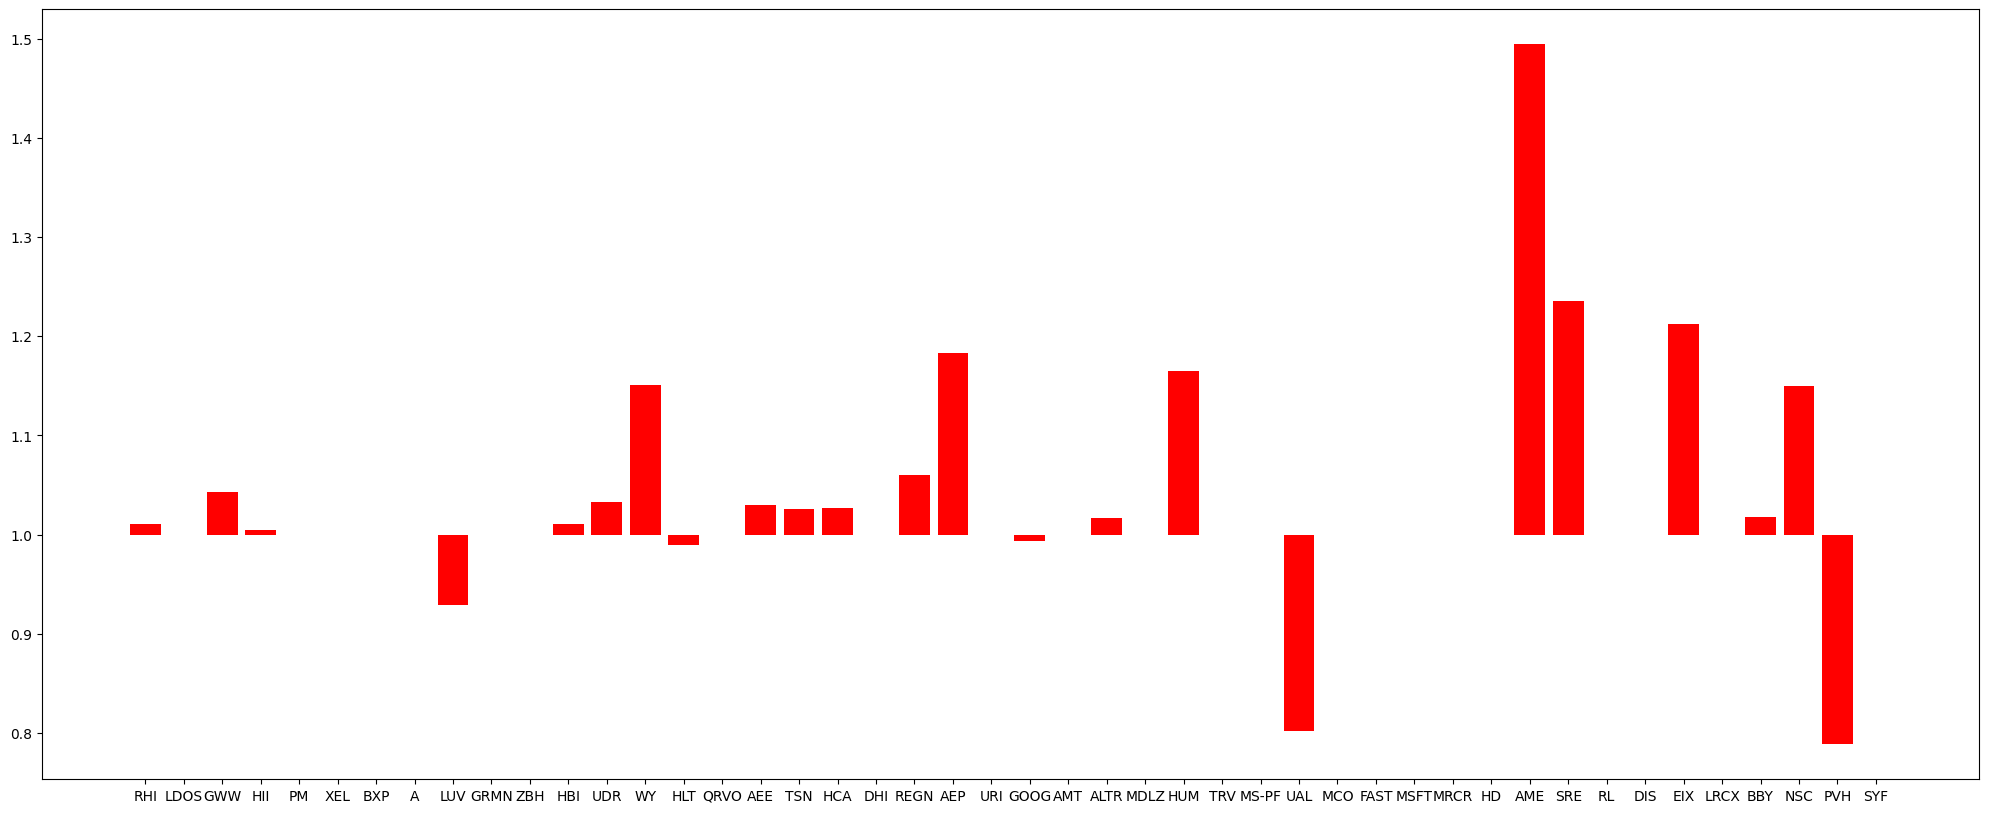

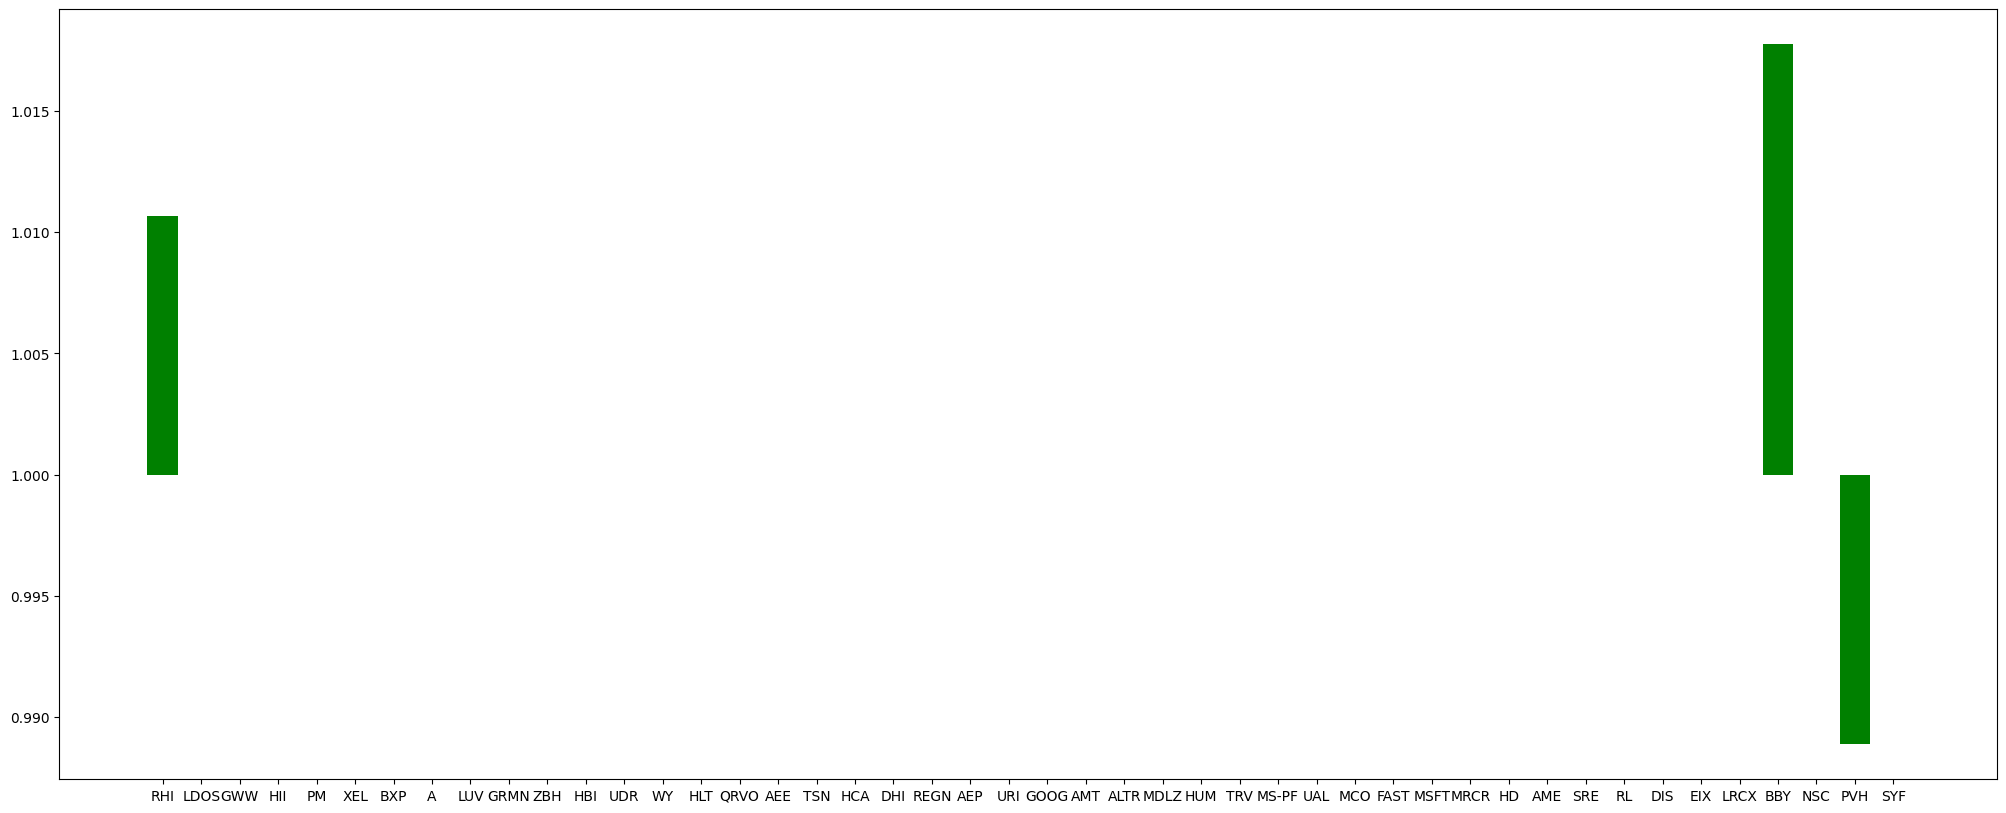

In [17]:
import random


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(25, 10))

vals = -((len(stock_value)//10)*9)

stock_value = [each - 1 for each in stock_value]
ax.bar(stock_name[:][:vals], stock_value[:vals], bottom=1, color='blue', label='SVM')

plt.savefig("SVM_percent.PNG")
plt.show()




fig, ax = plt.subplots(figsize=(25, 10))


stock_value_lr = [each - 1 for each in stock_value_lr]
ax.bar(stock_name[:][:vals], stock_value_lr[:vals], bottom=1, color='red', label='LR')

plt.savefig("LR_percent.PNG")
plt.show()






fig, ax = plt.subplots(figsize=(25, 10))


stock_value_combo = [each - 1 for each in stock_value_combo]
ax.bar(stock_name[:][:vals], stock_value_combo[:vals], bottom=1, color='green', label='SVM_with_LR')

plt.savefig("SVM_with_LR_percent.PNG")
plt.show()



In [16]:
import math
stock_value = [each + 1 for each in stock_value]
stock_value_lr = [each + 1 for each in stock_value_lr]
stock_value_combo = [each + 1 for each in stock_value_combo]

SVM_all_stocks = math.prod(stock_value)
LR_all_stocks = math.prod(stock_value_lr)
SVM_with_LR_all_stocks = math.prod(stock_value_combo)

print(SVM_all_stocks, LR_all_stocks, SVM_with_LR_all_stocks)

12.896208648418595 0.015825819246249248 1.4566992271135166


In [14]:
print(stock_value)
print(stock_value_lr)
print(stock_value_combo)

[np.float64(1.0503638085079134), 1, np.float64(1.005600635812361), 1, np.float64(1.026615180024413), 1, 1, 1, 1, 1, 1, np.float64(0.8625488777861783), 1, np.float64(1.0376489775340103), 1, np.float64(1.0004568420303703), 1, np.float64(0.9960615015153618), 1, 1, np.float64(1.079726448360728), 1, np.float64(0.9360088732535946), 1, 1, np.float64(1.011548722194465), 1, 1, 1, 1, 1, 1, np.float64(0.9925372722310062), 1, 1, 1, 1, 1, np.float64(0.9384797928059784), 1, 1, np.float64(0.9989829284537075), np.float64(0.962188150269238), np.float64(1.0253753899668498), np.float64(1.32301087138147), 1, 1, np.float64(1.0060843483064792), 1, 1, np.float64(1.046992284380257), np.float64(1.0576674240487456), 1, np.float64(1.5297638428380311), np.float64(1.0403990374818366), 1, np.float64(0.814137272594003), np.float64(0.836823007316852), 1, np.float64(0.9951344082074808), np.float64(1.054560270211038), np.float64(0.9810391419307835), 1, 1, 1, np.float64(0.9914803066260862), 1, 1, 1, 1, 1, np.float64(1.0